## Imports

In [29]:
import pathlib
import pickle

import torch
from torchvision import transforms
from torch.utils.data import DataLoader

from super_resolution.src.sen2venus_dataset import create_train_validation_test_split
from super_resolution.src.visualization import plot_gallery

## Constants

In [28]:
DATA_DIR = pathlib.Path("C:/Users/Mitch/stat3007_data")
SITES_DIR = DATA_DIR / "sites"
PREPROCESSING_DIR = DATA_DIR / "preprocessing"

## Basic data loading

In [17]:
train_patches, val_patches, test_patches = create_train_validation_test_split(
    str(SITES_DIR) + "\\", seed=42, sites={"K34-AMAZ"}
)
print(
    f"Num train {len(train_patches)}\n"
    f"Num validation {len(val_patches)}\n"
    f"Num test {len(test_patches)}"
)

Num train 969
Num validation 208
Num test 208


In [18]:
train_loader = DataLoader(train_patches, batch_size=5, shuffle=True)

In [19]:
for i, (low_res, high_res) in enumerate(train_loader):
    print(
        f"batch {i}\n"
        f"low resolution batch shape {low_res.shape}\n"
        f"high resolution batch shape {high_res.shape}\n"
    )

    if i == 2:
        break

batch 0
low resolution batch shape torch.Size([5, 3, 128, 128])
high resolution batch shape torch.Size([5, 3, 256, 256])

batch 1
low resolution batch shape torch.Size([5, 3, 128, 128])
high resolution batch shape torch.Size([5, 3, 256, 256])

batch 2
low resolution batch shape torch.Size([5, 3, 128, 128])
high resolution batch shape torch.Size([5, 3, 256, 256])



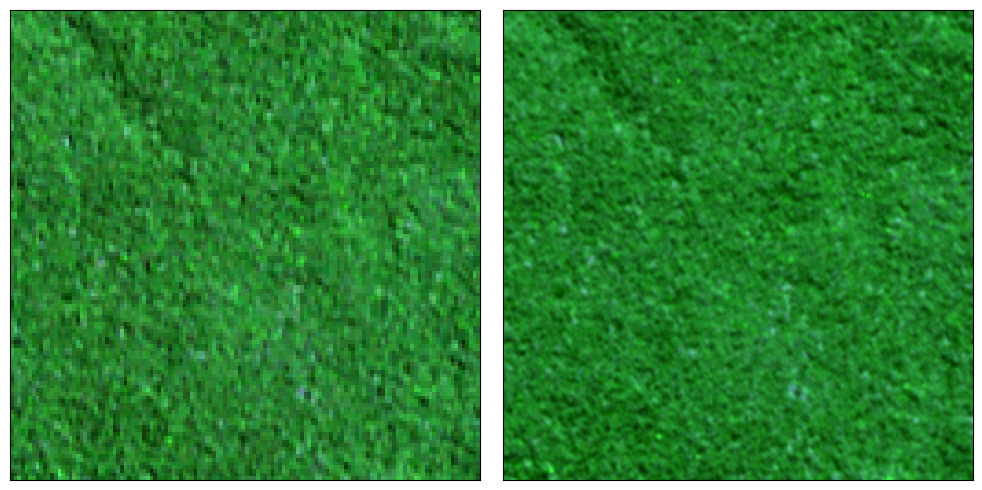

In [20]:
low_res_example = low_res[0]
high_res_example = high_res[0]
plot_gallery(
    [low_res_example.permute(1, 2, 0), high_res_example.permute(1, 2, 0)],
    xscale=5,
    yscale=5,
)

## Data loading with transforms

We often want to apply some static transforms calculated from our training set and apply these
to both the training set and test sets before running data through our model.

In [90]:
# Compute mean and standard deviation for each channel (averaged over samples).
train_loader = DataLoader(train_patches, batch_size=1000)

low_mean = 0.0
low_std = 0.0
high_mean = 0.0
high_std = 0.00
for i, (low_res, high_res) in enumerate(train_loader):
    low_mean += torch.sum(torch.mean(low_res, (2, 3)), 0)
    high_mean += torch.sum(torch.mean(high_res, (2, 3)), 0)
    low_std += torch.sum(torch.std(low_res, (2, 3)), 0)
    high_std += torch.sum(torch.std(high_res, (2, 3)), 0)
low_mean /= len(train_patches)
low_std /= len(train_patches)
high_mean /= len(train_patches)
high_std /= len(train_patches)

print(
    f"Low resolution:\n"
    f"Channel means {low_mean}\n"
    f"Channel standard deviations {low_std}\n"
    "\n"
    f"High resolution:\n"
    f"Channel means {high_mean}\n"
    f"Channel standard deviations {high_std}\n"
)

In [59]:
save_file = PREPROCESSING_DIR / "K34-AMAZ_mean_std.pkl"

Computing the mean and std can be slow. Here is some code for saving and loading the data.

In [60]:
# with open(save_file, "wb") as file:
#     pickle.dump((mean, std), file)

In [61]:
# with open(save_file, "rb") as file:
#     mean, std = pickle.load(file)

In [88]:
def custom_transform(patches: torch.Tensor) -> torch.Tensor:
    # torchvision transforms expects shape (CxHxW)
    patches = patches.permute(0, 2, 1)
    augmentations = transforms.Compose(
        [transforms.Normalize(low_mean, high_std), transforms.ColorJitter()]
    )
    return augmentations(patches).permute(0, 2, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


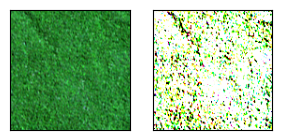

In [89]:
plot_gallery(
    [
        low_res_example.permute(1, 2, 0),
        custom_transform(low_res_example).permute(1, 2, 0),
    ]
)

## Train Loop Example